<a href="https://colab.research.google.com/github/Zulfahanamaulida/TA_Deteksi-Residu-Pestisida/blob/main/28_28_Arsitektur_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data input : Data tabular binary dari citra 0 (without_pesticide) dan 10 (with_pesticide) mg/l| Tanpa ROI

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define the path to the directory containing the dataset
dataset_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/'

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
with_pesticide_data = pd.read_csv("/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/with_pesticide.csv")
without_pesticide_data = pd.read_csv("/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/without_pesticide.csv")

# Split the datasets into features and labels
X_with_pesticide = with_pesticide_data.drop(columns=['label'])  # Assuming 'label' is the column name for the class
y_with_pesticide = with_pesticide_data['label']

X_without_pesticide = without_pesticide_data.drop(columns=['label'])  # Assuming 'label' is the column name for the class
y_without_pesticide = without_pesticide_data['label']

# Split the datasets into training and testing sets (70% train, 30% test)
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X_with_pesticide, y_with_pesticide, test_size=0.3, random_state=42)
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(X_without_pesticide, y_without_pesticide, test_size=0.3, random_state=42)

# Merge the train and test datasets for both classes
X_train = pd.concat([X_train_with, X_train_without])
y_train = pd.concat([y_train_with, y_train_without])
X_test = pd.concat([X_test_with, X_test_without])
y_test = pd.concat([y_test_with, y_test_without])

# Define paths for train and test folders
train_folder = "/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/Split_Data/A/"
test_folder = "/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/Split_Data/A/"

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Save the datasets into train and test folders
X_train.to_csv(os.path.join(train_folder, 'X_train.csv'), index=False)
y_train.to_csv(os.path.join(train_folder, 'y_train.csv'), index=False)
X_test.to_csv(os.path.join(test_folder, 'X_test.csv'), index=False)
y_test.to_csv(os.path.join(test_folder, 'y_test.csv'), index=False)

print("Datasets split, merged, and saved successfully.")


Datasets split, merged, and saved successfully.


In [5]:
# Convert DataFrame to numpy array
X_train_without_pesticide = X_train_without.values.astype('float32')
X_test_without_pesticide = X_test_without.values.astype('float32')
X_train_with_pesticide = X_train_with.values.astype('float32')
X_test_with_pesticide = X_test_with.values.astype('float32')

# Assuming that your images are flattened, reshape them into 256x256
X_train_without_pesticide = X_train_without_pesticide.reshape(-1, 28, 28, 1)
X_test_without_pesticide = X_test_without_pesticide.reshape(-1, 28, 28, 1)
X_train_with_pesticide = X_train_with_pesticide.reshape(-1, 28, 28, 1)
X_test_with_pesticide = X_test_with_pesticide.reshape(-1, 28, 28, 1)

# Concatenate data
X_train = np.concatenate((X_train_without_pesticide, X_train_with_pesticide), axis=0)
X_test = np.concatenate((X_test_without_pesticide, X_test_with_pesticide), axis=0)

# Create labels
y_train = np.concatenate((np.zeros(X_train_without_pesticide.shape[0]), np.ones(X_train_with_pesticide.shape[0])))
y_test = np.concatenate((np.zeros(X_test_without_pesticide.shape[0]), np.ones(X_test_with_pesticide.shape[0])))

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [6]:
def VGG_16(_input=Input((28, 28, 1))):
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(_input)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D((2, 2))(conv4)
    global_pool = GlobalAveragePooling2D()(pool2)
    dense1 = Dense(256, activation='relu')(global_pool)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(2, activation='softmax')(dense2)
    VGG16_model = Model(inputs=_input, outputs=output)
    return VGG16_model

# Instantiate the model
model = VGG_16()

# Define learning rate
learning_rate = 0.0001

# Define your optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=3)])
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147584    
                                                             

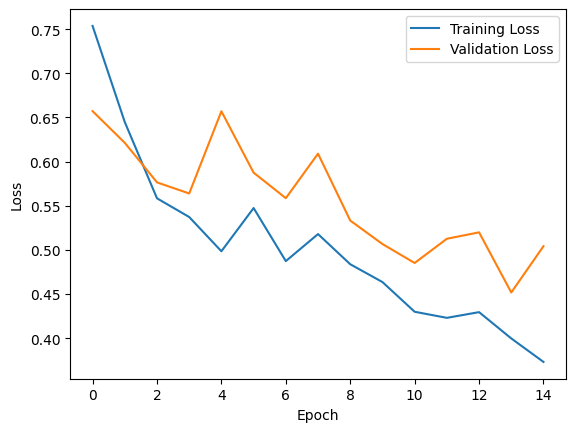

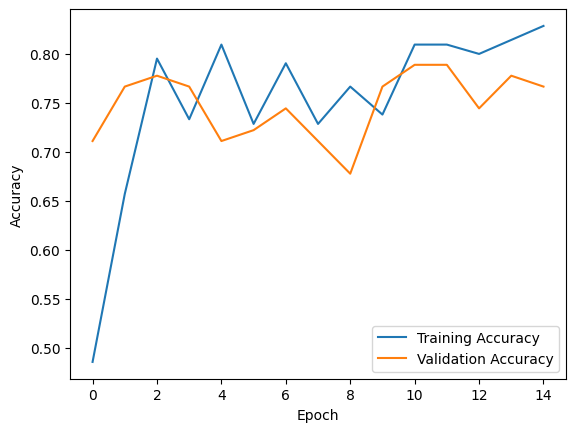

In [7]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3/3 [==============================] - 0s 86ms/step


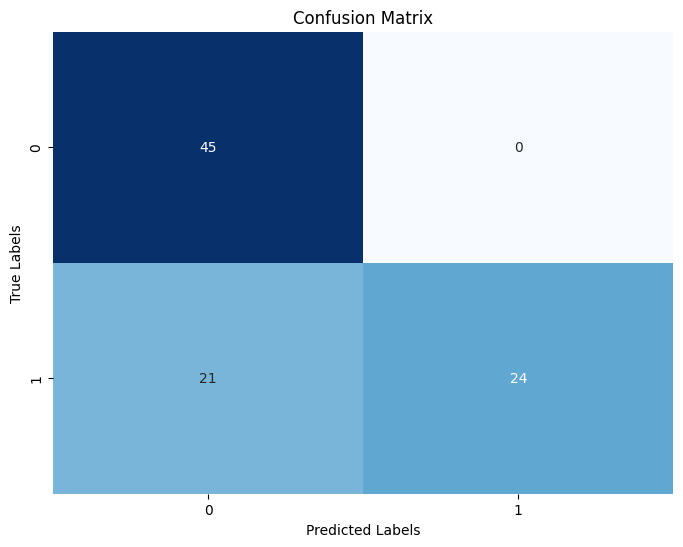

Classification Report:
               precision    recall  f1-score   support

           0       0.68      1.00      0.81        45
           1       1.00      0.53      0.70        45

    accuracy                           0.77        90
   macro avg       0.84      0.77      0.75        90
weighted avg       0.84      0.77      0.75        90



In [8]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes)

# Print classification report
print("Classification Report:\n", class_report)


In [10]:
# Define the path to save the model
save_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Arsitektur VGG16/Percobaan 6/A/model.h5'

# Save the trained model
model.save(save_path)
print("Model saved at:", save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at: /content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Arsitektur VGG16/Percobaan 6/A/model.h5
